## Spiking data on Nengo - Tutorial
[Code cred](https://www.nengo.ai/nengo-examples/loihi/dvs-from-file.html)  
This tutorial covers the following:
- Format of spiking camera data
- How to utilize built in Nengo tools to read spiking camera data
- How to run spiking camera data through Nengo neurons
***
#### Motivation
Many times we process spiking data into regular images, then perform image processing (such as detection and classification) using traditional CPUs. This is a valid way to do things!   

BUT WHAT IF we instead feed the spiking data straight into neurons?? We can then just perform the image processing with neurons as well, further reducing power consumption and keeping the dimensionality of data reduced to events.  
 
***

### Resources
If you are interested in using spiking data for your final project, take a look at a bunch of options [here](https://rpg.ifi.uzh.ch/davis_data.html), [here](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2016.00405/full), and [here](https://docs.prophesee.ai/stable/datasets.html#chapter-datasets)
 -- or ask Dr. York or the Physics department.

[This website](https://rpg.ifi.uzh.ch/research_dvs.html) consolidates a lot of spiking-data resources.

[This survey paper](https://rpg.ifi.uzh.ch/docs/EventVisionSurvey.pdf) discusses different event-based cameras available and how they are processed in sections 2.5 and 3.1 respectively.  
  
***

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  

You will need to run `pip install nengo-loihi` within your virtual environment before you begin.
    
Then, import Nengo, NengoLoihi, and other supporting libraries into your program to get started:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import ArtistAnimation

import nengo
import nengo_loihi

import pandas as pd

### Load your data (in the correct format)

Hopefully you recall our discussion on event-based data earlier in the semester. If not, take a look back at Lecture 6.

Hopefully you also recall building and utilizing Address Event Representation during our Path Planning lab. Combine those two concepts and you have spiking-camera data.

We have spiking-camera data containing pixel-coordinates with a timestamp of an event occuring along with it's polarity (0 or 1) from the Physics department as well as from Dr. York. However, Nengo has an easy way to feed this data to neurons IF it's in an *.events file type - which is (I believe) and outdated way to concisely store a very large AER table. BUT we can easily convert it with a few lines of code.

We can convert our spiking data to the *.events data file format via `nengo_loihi.dvs.DVSEvents()` - read about all of these DVS functions [here](https://www.nengo.ai/nengo-loihi/api.html#dvs). We can then use that to send spiking data to Nengo neuron ensembles for processing. The *.events file contains the an array for every event consisting of the following values:   
- `y`: The vertical coordinate of the event.
- `x`: The horizontal coordinate of the event.
- `p`: The polarity of the event (0 for off, 1 for on).
- `v`: The event trigger (0 for camera events, 1 for external events). In our case, these will all be 0.
- `t`: The event timestamp in microseconds.

LtCol Jurado kindly created a function `csv_to_event_array` that reads a csv file (our data) and converts it to the *.events file that Nengo can easily read and use.

**Other fun things about data**  
We can also generate data if we don't have our own (copy code from [here](https://www.nengo.ai/nengo-examples/loihi/dvs-from-file.html)). AND there are even Github repositories [like this one](https://github.com/SensorsINI/v2e) out there where you can take any data you'd like and convert it to spiking data like this. 

In [3]:
# LtCol Jurado's Python wizardry
def csv_to_event_array(
    csv_filename: str, start_frame: int, end_frame: int
) -> np.ndarray:
    # ======= DVS camera - Physics dept ===========
    df = pd.read_csv(csv_filename, names=["x", "y", "p", "t"])
    # ======== Prophesee camera - ECE dept ========
    # == read every nth frame ==
    # skip = np.arange(int(10e6))
    # skip = np.delete(skip, np.arange(0, int(10e6), 50))
    # df = pd.read_csv(csv_filename, names=['x', 'y', 'p', 't'], skiprows=skip)

    df["v"] = np.zeros(len(df), dtype=int)
    sub_df = df[(start_frame <= df["t"]) & (df["t"] <= end_frame)]

    events_list = [(y, x, p, v, t) for x, y, p, t, v in sub_df.values]
    events_array = np.array(
        events_list,
        dtype=[("x", "i4"), ("y", "i4"), ("p", "i4"), ("t", "i4"), ("v", "i4")],
    )

    return events_array


# the csv file we will convert and the time range of our events

# ======= DVS camera - Physics dept ===========
csv_filename = "ILAN City Frame Data.csv"
start_time = 585861
end_time = 685846
# =============================================


# ======== Prophesee camera - ECE dept ========
# csv_filename = 'prophesee.csv'
# start_time = 5e6
# end_time = 10e6
# =============================================


# use the fancy function to turn this into the format Nengo likes
events = csv_to_event_array(csv_filename, start_time, end_time)
dvs_events = nengo_loihi.dvs.DVSEvents()
# this is really where the conversion happens
dvs_events.init_events(event_data=events)

# Save it as a *.events file!
events_file_name = "dvs-from-file-events.events"
dvs_events.write_file(events_file_name)
print("Wrote %r" % events_file_name)

Wrote 'dvs-from-file-events.events'


### View the data (NOT using neurons yet)

This is all just a lot of python-ness to display a video. However, notice that we are reading it NOT from the *.csv but instead from our dvs_events data that we just created.

Big takeaway - we are adding up events over a window of time. Our events occur over the course of 100ms. We take .1ms chunks and set any pixels within that 100ms with an event to 1 (or -1 should we have a polarity of 0). This gives us 100 frames.

Also note, we've just written the file using `dvs_events`. If we already had an *.events file, we could skip the last block of code and just call `dvs_events = nengo_loihi.dvs.DVSEvents.from_file(events_file_name)`.

You can read all about animations [here](https://matplotlib.org/stable/users/explain/animations/animations.html).

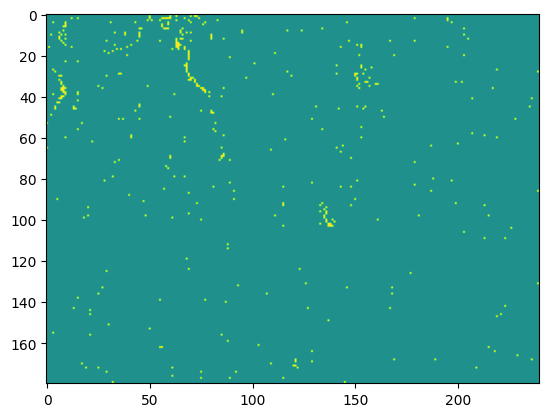

In [12]:
dvs_events = nengo_loihi.dvs.DVSEvents.from_file(events_file_name)

# ======== Prophesee camera - ECE dept ========
# img_height = 720
# img_width = 1280
# t_length_us = end_time - start_time
# t_length_s = t_length_us #t_length_us*10e-6
# dt_frame_us = 10e4 #10e3
# t_frames = dt_frame_us * np.arange(int(round(t_length_us / dt_frame_us)))
# =============================================

# ======= DVS camera - Physics dept ===========
img_height = 180
img_width = 240
t_length_us = end_time - start_time
t_length_s = t_length_us * 10e-6
dt_frame_us = 10e3
t_frames = dt_frame_us * np.arange(int(round(t_length_us / dt_frame_us)))
# =============================================


fig = plt.figure()
imgs = []
for t_frame in t_frames:
    t0_us = t_frame + start_time
    t1_us = t0_us + dt_frame_us
    t = dvs_events.events[:]["t"]
    m = (t >= t0_us) & (t < t1_us)
    events_m = dvs_events.events[m]

    # show "off" (0) events as -1 and "on" (1) events as +1
    events_sign = 2.0 * events_m["p"] - 1

    frame_img = np.zeros((img_height, img_width))
    frame_img[events_m["y"], events_m["x"]] = events_sign

    # for subframe in events_m:
    #    frame_img[subframe[0], subframe[1]] += subframe[2]

    img = plt.imshow(frame_img[:, ::-1], vmin=-1, vmax=1, animated=True)
    imgs.append([img])

ani = ArtistAnimation(fig, imgs, interval=50, blit=True)
HTML(ani.to_jshtml())

### Build your model
We can now load our data into a Nengo model using the `nengo_loihi.dvs.DVSFileChipProcess` type of `nengo.Process`. When run in a `nengo.Simulator`, this process passes the DVS events read from the *.events file directly to the model. 

You can read about `nengo_loihi.dvs.DVSFileChipProcess` [here](https://www.nengo.ai/nengo-loihi/api.html#dvs).
- `file_path`:The path of the file to read from. Can be a .aedat or .events file. Format of the file will be detected from the file extension.
- `pool`: Number of pixels to pool over in the vertical and horizontal directions, respectively. The larger the pool, the fewer neurons required.
- `channels_last`: Whether to make the channels (i.e. the polarity) the least-significant index (True) or the most-significant index (False).

To read about how to use enumerate in loop, look [here](https://www.geeksforgeeks.org/enumerate-in-python/). This will be useful for connecting arrays of neuron ensembles in your final project as it eliminates the need for indexing inside of a loop. You instead just call the second argument (in this example: `e`). _Probably should have used this in path planning - oops_.

`dvs_process.polarity` is the number of polarity values in the data. In this case we have 2: one for positive events, one for negative. The `::` is called a "stride" and can be used to skip through an array by a certain amount. In this case, we start at the $k^{th}$ value (0 or 1) and stride by 2. You can find some easier examples [here](https://scipython.com/book/chapter-2-the-core-python-language-i/examples/string-striding/).

Otherwise - this should all look familiar!

In [13]:
# ======= DVS camera - Physics dept ===========
pool = (2, 2)

# ======== Prophesee camera - ECE dept ========
# pool = (10, 10)


model = nengo.Network(label="Spiking Data")
with model:
    dvs_process = nengo_loihi.dvs.DVSFileChipProcess(
        file_path=events_file_name, pool=pool, channels_last=True
    )
    u = nengo.Node(dvs_process)

    ensembles = [
        nengo.Ensemble(dvs_process.height * dvs_process.width, 1)
        for _ in range(dvs_process.polarity)
    ]

    for k, e in enumerate(ensembles):
        u_channel = u[k :: dvs_process.polarity]
        nengo.Connection(u_channel, e.neurons, transform=1.0 / np.prod(pool))

    probes = [nengo.Probe(e.neurons) for e in ensembles]

with nengo.Simulator(model) as sim:
    sim.run(1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

### View the data (using Nengo neurons!)

This looks very much the same as viewing the data with regular Python - except now we are reading spikes from our probed neurons!

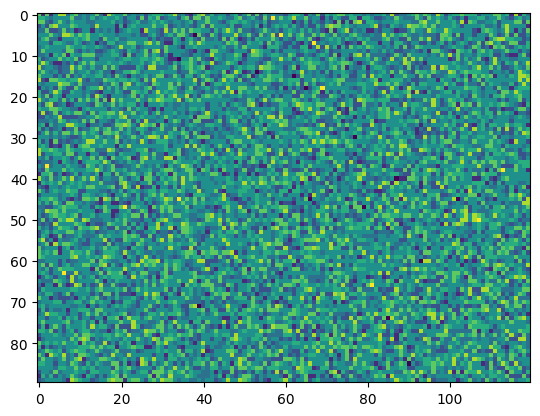

In [14]:
sim_t = sim.trange()
shape = (len(sim_t), dvs_process.height, dvs_process.width)
output_spikes_neg = sim.data[probes[0]].reshape(shape) * sim.dt
output_spikes_pos = sim.data[probes[1]].reshape(shape) * sim.dt

dt_frame = 0.01
t_frames = dt_frame * np.arange(int(round(t_length_s / dt_frame)))

fig = plt.figure()
imgs = []
for t_frame in t_frames:
    t0 = t_frame
    t1 = t_frame + dt_frame
    m = (sim_t >= t0) & (sim_t < t1)

    frame_img = np.zeros((dvs_process.height, dvs_process.width))
    frame_img -= output_spikes_neg[m].sum(axis=0)
    frame_img += output_spikes_pos[m].sum(axis=0)
    frame_img = frame_img / np.abs(frame_img).max()

    img = plt.imshow(frame_img[:, ::-1], vmin=-1, vmax=1, animated=True)
    imgs.append([img])

ani = ArtistAnimation(fig, imgs, interval=50, blit=True)
HTML(ani.to_jshtml())

### Discussion

This simulation starts at t=0 and runs through full t=1. So we just have noise on either side of the actual data whereas using regular python we only plotted the data of interest.

Also notice the noise is HIGH. That's because neurons are inherently noisy. 

**_So again, why did we do this?_**   

It seemed like a lot of work to just print the data again... right??

Well, now we know we can effectively send the data through neurons, which means we can now start processing the data with neurons and maintain the efficiencies we gained by collecting event-based data in the first place. COOL!